<h1>Natural Language Processing with Disaster Tweets</h1>

<a id = 'intro'></a>
# Introduction
<br>
This competition involves predicting which tweets are about actual disasters and which are not. The goal of this project is to get a submission CSV file which lists the tweet IDs with respective targets: any tweet that is about a disaster is marked with a 1; any non-disaster related tweet is marked 0. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


In [2]:
# Get current working directory
os.getcwd()

'/kaggle/working'

<a id='EDA'></a>
# Exploratory Data Analysis
Before getting information on the training data, take a look at what the sample submission is expected to be. 

In [3]:
sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Now, get basic information on the training data. Look at the train.csv file and get the first five rows of tweets.

In [4]:
# Get info on the training data
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Get the columns' names on the train data
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [6]:
# Get the train data structure's shape
train_data.shape

(7613, 5)

In [7]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
# Get general info on train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
# Get the count of unique values on train dataset
train_data.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [10]:
# Get descriptive statistics on train_data
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Now, get information on the test data. 

In [11]:
# Get info on the test data
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
test_data.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [13]:
test_data.shape

(3263, 4)

In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [15]:
# Check on the number of unique elements
test_data.nunique()

id          3263
keyword      221
location    1602
text        3243
dtype: int64

In [16]:
# Get descriptive statistics on the test data
test_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [17]:
# Compare the train and test data info and shapes
print(train_data.info(), test_data.info())
print(train_data.shape, test_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None None
(7613, 5) (3263, 4)


In [18]:
# Remove the columns location, id from test_data; not necessary
test_data = test_data.loc[:, ['keyword', 'text']]
test_data

,keyword,text
0,NaN,Just happened a terrible car crash
1,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,NaN,Storm in RI worse than last hurricane. My city...
3260,NaN,Green Line derailment in Chicago http://t.co/U...
3261,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [19]:
# Get more info on train_data
print(train_data.columns)
train_data

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [20]:
len(train_data[train_data['keyword'].isna()])

61

In [21]:
len(train_data[train_data['location'].isnull() | train_data['location'].isna()])

2533

In [22]:
# Goal of the project is to match tweets with intended target (disastorous tweet marked 1; 0 otherwise)
# Drop the id and location columns from the train_data frame
train_data = train_data.loc[:, ['keyword', 'text', 'target']]
train_data

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,Police investigating after an e-bike collided ...,1


In [23]:
train_data['keyword'].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [24]:
test_data['keyword'].value_counts()

keyword
deluged          23
rubble           22
demolished       22
obliteration     21
annihilation     21
                 ..
fatalities        5
threat            5
forest%20fire     5
inundation        4
epicentre         1
Name: count, Length: 221, dtype: int64

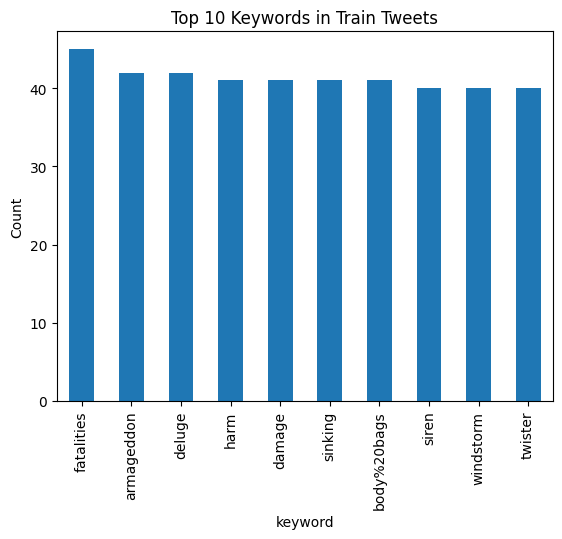

In [25]:
train_data['keyword'].value_counts().head(10).plot.bar()
plt.title("Top 10 Keywords in Train Tweets")
plt.ylabel("Count")
plt.show()

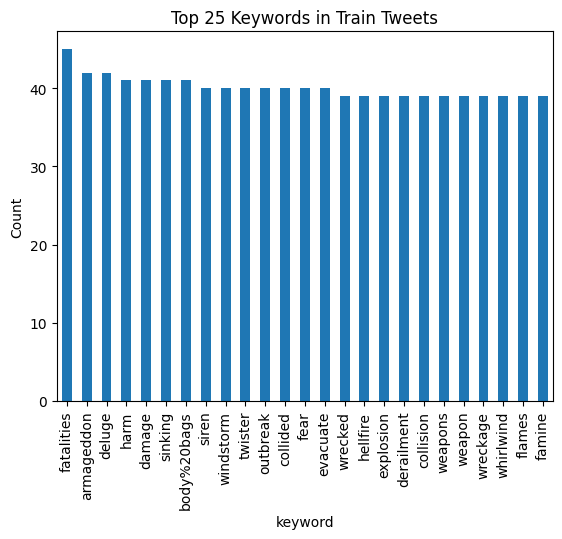

In [26]:
train_data['keyword'].value_counts().head(25).plot.bar()
plt.title("Top 25 Keywords in Train Tweets")
plt.ylabel("Count")
plt.show()

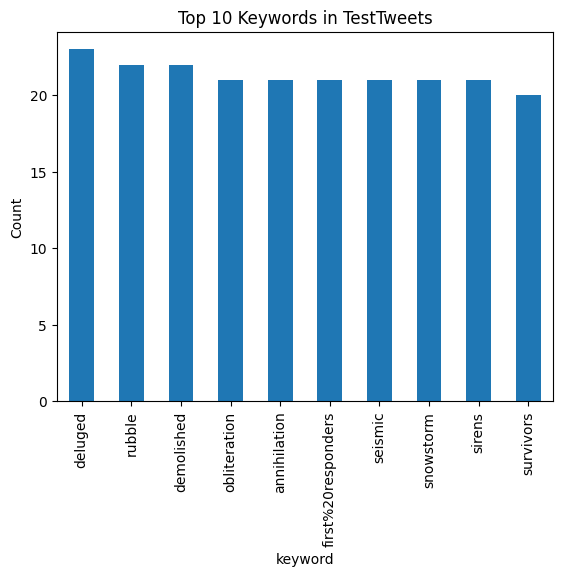

In [27]:
# A plot of the test data
test_data['keyword'].value_counts().head(10).plot.bar()
plt.title("Top 10 Keywords in TestTweets")
plt.ylabel("Count")
plt.show()

In [28]:
train_data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

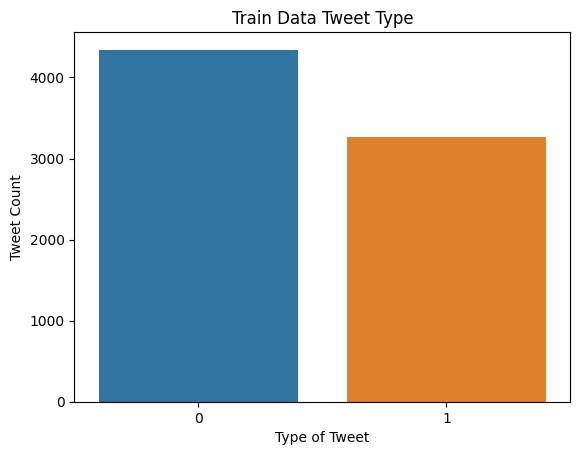

In [29]:
sns.countplot(train_data, x='target')
plt.xlabel("Type of Tweet")
plt.ylabel("Tweet Count")
plt.title("Train Data Tweet Type")
plt.show()

<a id='Data Preparation'></a>
# Data Preparation & Preprocessing
Some data cleaning will be required because there is more than text that is in the tweets. 
<br>
Prepare the training data before modeling. Install the necessary Keras and TensorFlow libraries to compare and build models to get the results.<br>
Also, this is the opportunity for presetting the Keras model and preprocessing the training data.

In [30]:
# Text cleaning is required since there are mentions, retweets, URLs, emojis, etc. that could be in the tweets. Remove these.
# These are the libraries for text modifications
import re
import emoji
!pip install contractions
import contractions
import html

# Create function to clean up the tweets to be plain text
# Get rid of additional characters or symbols
# Credit belongs to https://www.kaggle.com/code/muhammadfaseeh/kerasnlp-starter-notebook-disaster-tweets
def get_clean_tweets(text):
    
    # Rid the tweets of any extra spaces leading or following the first or last word
    text = text.strip()
    
    # Convert HTML entities
    text = html.unescape(text)
    
    # Fix corrupted Unicode artifacts
    text = text.replace("‰ÛÏ", '"').replace("‰Û", '"')  # Fix double quotes
    text = text.replace("‰Û÷", "'").replace("‰Ûª", "'")  # Fix single quotes
    text = text.replace("‰Û¢", "-").replace("‰Û_", "-")  # Fix hyphen issues
    
    # Remove any remaining corrupted symbols
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove remaining non-ASCII characters
    
    # Remove URLs that start with 'https://...' or any links
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove any emojis - had no idea that there was a library that could get this done
    text = emoji.demojize(text, delimiters=(" ", " "))  
    
    # Expand contractions
    text = contractions.fix(text)

    return text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 10.7 MB/s eta 0:00:00


In [31]:
# Apply to both train and test tweets columns in datasets
train_data['text'] = train_data['text'].apply(get_clean_tweets)
test_data['text'] = test_data['text'].apply(get_clean_tweets)

In [32]:
train_data['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609      The out of control wild fires in California ...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [33]:
test_data['text']

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES  SAFETY FASTENER...
3259    Storm in RI worse than last hurricane. My city...
3260                    Green Line derailment in Chicago 
3261          MEG issues Hazardous Weather Outlook (HWO) 
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [34]:
# Import the appropriate libraries to split up the training data
import tensorflow as tf
import keras
import keras_nlp
from keras import layers
from keras.layers import TextVectorization
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

2025-06-22 07:50:33.180094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750578633.376499      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750578633.432665      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [35]:
# Get tensorflow, keras, keras_nlp versions
print(tf.__version__,
keras.__version__,
keras_nlp.__version__)

2.18.0 3.8.0 0.18.1


In [36]:
# Set batch size and get the text column for x; target column for y
BATCH_SIZE = 16
RANDOM_STATE = 101

x = train_data['text']
y = train_data['target']

In [37]:
print(type(x), type(y), len(x), len(y))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> 7613 7613


In [38]:
# Split up the data into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

x_test = test_data['text']

In [39]:
len(x), len(y)

(7613, 7613)

In [40]:
print(len(x_train), len(y_train), len(x_valid), len(y_valid))

6090 6090 1523 1523


In [41]:
print(type(x_train), type(x_valid), type(y_train), type(y_valid), type(x_test))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [42]:
x_train.shape

(6090,)

<a id='Model'></a>
# Training the Model

Now, time to train the model. <br>
Re-compile the data, optimize the model, and then fit the data into the model. 

In [43]:
''' Credit for utilizing the model below deservedly goes to the following notebook: 
https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets#Preprocess-the-data

I would not have learned about the different kinds of models that Keras has to offer with text classification without seeing what was possible with the models implemented and the information it had 
in comparison and research to other preser Keras English language recognition models. This made work on this project much easier. 
'''

# Load DistilBERT model, uncased and based.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length - 140
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=140,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrain the classifier for model
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

I0000 00:00:1750578648.944448      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750578648.945142      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Re-compile data with different learning rate

classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(1e-5),
                  metrics=['accuracy'])

In [45]:

# Fit the data into the model
# Set number of epochs to 10
model = classifier.fit(x=x_train, 
          y=y_train,
          batch_size=BATCH_SIZE,
       validation_data=(x_valid,y_valid),
           epochs=10
)

Epoch 1/10


I0000 00:00:1750578680.171649      66 service.cc:148] XLA service 0x7cfcf4003470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750578680.172170      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750578680.172193      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750578682.483925      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750578699.464981      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 ━━━━━━━━━━━━━━━━━━━━ 164s 314ms/step - accuracy: 0.7491 - loss: 0.5434 - val_accuracy: 0.8299 - val_loss: 0.3921
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 109s 286ms/step - accuracy: 0.8577 - loss: 0.3611 - val_accuracy: 0.8378 - val_loss: 0.3875
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 108s 284ms/step - accuracy: 0.8820 - loss: 0.3163 - val_accuracy: 0.8306 - val_loss: 0.4087
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 110s 287ms/step - accuracy: 0.9003 - loss: 0.2688 - val_accuracy: 0.8293 - val_loss: 0.4343
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 109s 286ms/step - accuracy: 0.9155 - loss: 0.2373 - val_accuracy: 0.8280 - val_loss: 0.4607
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 109s 285ms/step - accuracy: 0.9339 - loss: 0.1916 - val_accuracy: 0.8207 - val_loss: 0.5220
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 109s 286ms/step - accuracy: 0.9414 - loss: 0.1608 - val_accuracy: 0.8273 - val_loss: 0.5521
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 109s 286ms/step - accuracy: 0.9481 - loss: 0.13

In [46]:
# Get logs - a full dictionary
print(model.history)

{'accuracy': [0.800656795501709, 0.8617405295372009, 0.8916256427764893, 0.9100164175033569, 0.9252873659133911, 0.9402298927307129, 0.951724112033844, 0.9587848782539368, 0.9640393853187561, 0.9707717299461365], 'loss': [0.4618181586265564, 0.3494594693183899, 0.29519525170326233, 0.24737878143787384, 0.2105705738067627, 0.16860345005989075, 0.13655482232570648, 0.11402351409196854, 0.09142020344734192, 0.07800612598657608], 'val_accuracy': [0.829940915107727, 0.8378201127052307, 0.8305975198745728, 0.8292843103408813, 0.8279711008071899, 0.820748507976532, 0.8273144960403442, 0.8194352984428406, 0.8122127652168274, 0.8063033223152161], 'val_loss': [0.39208322763442993, 0.38752835988998413, 0.4087079167366028, 0.4343373477458954, 0.46070390939712524, 0.5220147371292114, 0.5521045327186584, 0.617957353591919, 0.6902745962142944, 0.7519214749336243]}


In [47]:
# Get keys to save the training and validation logs percentages for each epoch
model.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
# number of values in each list should align to how many epochs were needed to train
loss = model.history['loss']
val_loss = model.history['val_loss']
accuracy = model.history['accuracy']
val_accuracy = model.history['val_accuracy']
print(len(loss), type(loss))

10 <class 'list'>


<a id='Plots'></a>
# Plotting Loss
Gather all the information from model's history and plot the curves to see how the training data did against the validation data. 

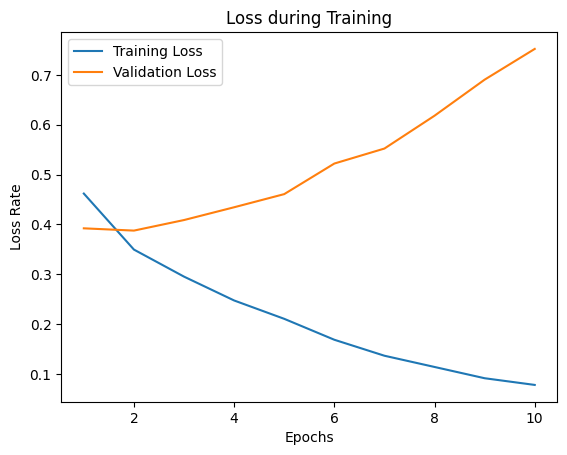

In [49]:
# Initialize x-axis for plots - first plot the loss
epochs = list(range(1, len(loss) + 1))

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title("Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Loss Rate")
plt.legend()
plt.show()

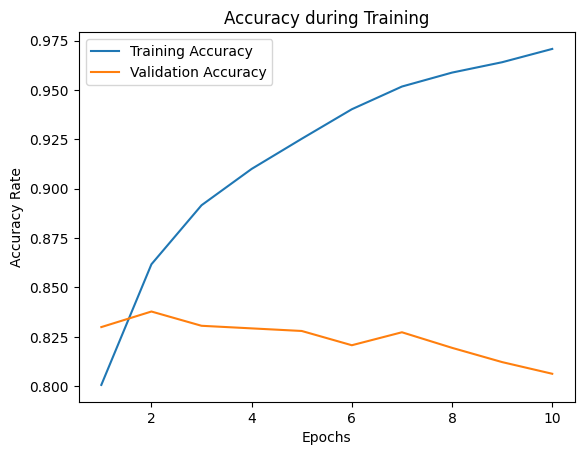

In [50]:
# Now plot the accuracy
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title("Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.show()

In [51]:
# Generate Confusion Matrix
def getConfusionMatrix(y_true, y_pred, data):
    matr = ConfusionMatrixDisplay.from_predictions(y_true, np.argmax(y_pred, axis=1),
                                                  display_labels=['Not Disaster Tweet', 'Disaster Tweet'])
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * ( (precision * recall) / (precision + recall))
    matr.ax_.set_title("Confusion Matrix on " + data + " Dataset -- F1 Score: " + str(f1.round(3)))
    print(precision, recall)


In [52]:
# Predict model on x_train 
y_pred_train = classifier.predict(x_train)

191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step


0.9838709677419355 0.9704545454545455


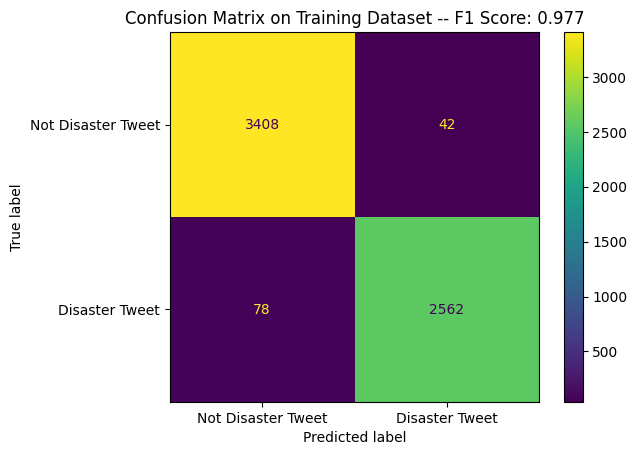

In [53]:
# Display the Confusion Matrix for training data
getConfusionMatrix(y_train, y_pred_train, "Training")

In [54]:
# Predict model on x_val 
y_pred_valid = classifier.predict(x_valid)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step


0.760061919504644 0.7781299524564184


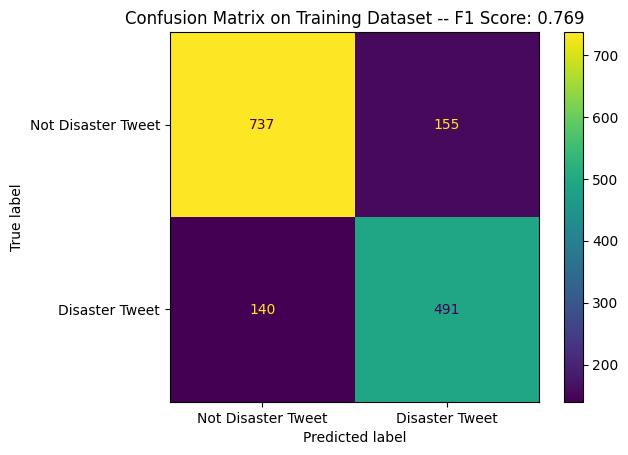

In [55]:
# Display the Confusion Matrix for the validation data
getConfusionMatrix(y_valid, y_pred_valid, "Training")

In [56]:
# Check the sample submission file
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


<a id='Conclusion'></a>
# Conclusion and Submission

It can be seen from the confusion matrices that we received some levels of accuracy running the preprocessing and modeling through DistilBERT. <br>
The F1 score received for the training data was 0.985, and the validation data 0.757, provided that the validation set was smaller than the training set. <br>
There was not much training loss between any of the epochs, as it stayed well below 10% most of the time. <br>
It can also be seen that there were a couple of sharp periods of increases when it came to the validation loss. <br>
As for the modeling accuracy, the training rate stayed well above 95%, while the validation data model epochs runs ranged anywhere from 79% to 82%. <br>
In the validation prediction confusion matrix, there was an equal number of false negative and false positive predictions with 150 and 158, respectively. <br>

<h2>Improvements</h2>
Any means of improvement can be made to how the text preprocessing was implemented. There certainly are better and more efficient ways of getting rid of extra characters prior to splitting and preprocessing for modeling. A more extensive data analysis and pre-preprocessing, though it may appear unnecessary, would have helped with garnering more accurate results. There were several processing errors trying to fit the data to the model because of how tweets that are text are not always text. Thus, any credit to fellow Kaggle users deserve much thanks, because this notebook would not have run properly without realizing how important it is to periodically look through some of the tweets line by line. 
<br>
Additionally, a different kind of model framework from Keras or TensorFlow would have netted different results. The use of a different count of epochs would have also given the model being trained more opportunities to improve its accuracy. 


In [57]:
# Alter the submission file column target with the predictions to submit
# Use x_test data for the prediction
sample['target'] = np.argmax(classifier.predict(x_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step


In [58]:
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [59]:
sample.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.423843
std,3146.427221,0.494242
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [60]:
# Create new submission CSV file - submit to 'submission.csv'
sample.to_csv('submission.csv', index=False)